# Performance as well as Validation benchmarks for activation function implementations in the different frameworks

# GPU versions only


Run the following if using Google Colab

In [1]:
! pip install --upgrade --no-cache-dir https://github.com/manassharma07/crysx_nn/tarball/main
! pip install IPython==7.7.0

     |████████████████████████████████| 8.2 MB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 12.9 MB/s 
     |████████████████████████████████| 14.5 MB 19.6 MB/s 
     |████████████████████████████████| 26.3 MB 1.7 MB/s 
  Created wheel for crysx-nn: filename=crysx_nn-0.1.6-py3-none-any.whl size=16785 sha256=e5f85be760f9ab68cee78843c8b0363768972c68e3022d47c82fb5786e215437
  Stored in directory: /tmp/pip-ephem-wheel-cache-6ivu6vk9/wheels/03/f2/75/44d7d7a633df57a5b8fcc71630e2452ea280c9aad937ebe2a0
Successfully built crysx-nn
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.

     |████████████████████████████████| 774 kB 11.9 MB/s 
     |████████████████████████████████| 340 kB 48.3 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: IPython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 2.0.10 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.7.0 which is incompatible.


In [27]:


import numpy as np
np.show_config()
print('numpy',np.__version__)
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.activation import Sigmoid_cupy, Sigmoid_grad_cupy
from crysx_nn.activation import Softmax_cupy, Softmax_grad_cupy
from crysx_nn.activation import ReLU_cupy, ReLU_grad_cupy
import crysx_nn
print('crysx_nn',crysx_nn.__version__)

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

import cupy as cp
print('cupy',cp.__version__)

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
numpy 1.19.2
crysx_nn 0.1.6
torch 1.10.0+cu111
tensorflow 2.7.0
cupy 9.4.0


## Ensure that evertyhing is only using GPU

In [28]:
torch.cuda.is_available()

True

In [29]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
Tesla K80


In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
tf.test.is_gpu_available()

True

In [32]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
print(tf.test.is_built_with_cuda())

True


In [34]:
# tf.debugging.set_log_device_placement(True)

## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [35]:
X_torch = torch.rand((300,100),requires_grad=True)
X_torch = X_torch.cuda()
print(X_torch.cpu())

tensor([[0.0246, 0.6959, 0.1862,  ..., 0.9414, 0.6671, 0.1007],
        [0.0120, 0.0344, 0.7181,  ..., 0.1802, 0.5848, 0.5270],
        [0.0993, 0.9282, 0.3344,  ..., 0.3759, 0.1500, 0.1033],
        ...,
        [0.7569, 0.4561, 0.0076,  ..., 0.5868, 0.2152, 0.5475],
        [0.7849, 0.5425, 0.2914,  ..., 0.8174, 0.5026, 0.9743],
        [0.7845, 0.2733, 0.9774,  ..., 0.9086, 0.6597, 0.2743]],
       grad_fn=<ToCopyBackward0>)


## Convert it to numpy for `crysx_nn`

In [36]:
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
print(X_crysx_nn.dtype)

float32


## Now finally convert it to a tensorflow tensor

In [37]:
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

## Benchmark ReLU

### Confirm that all frameworks give the same results

In [38]:
# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)

# CrysX
relu_crysx_nn_value = ReLU_cupy(X_cupy)

# Tensorflow
relu_tf_value = tf.nn.relu(X_tf)#tf.keras.activations.relu(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(relu_torch_value.cpu().detach().numpy() - relu_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(relu_torch_value.cpu().detach().numpy() - cp.asnumpy(relu_crysx_nn_value)).max())

Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

In [39]:
# Torch
print('PyTorch')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 relu_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 ReLU_cupy(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.relu(X_tf)


PyTorch
23.7 µs ± 6.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
134 µs ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
106 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [40]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o relu_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o ReLU_cupy(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 500 -o tf.nn.relu(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

52 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
134 µs ± 7.01 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
65.6 µs ± 8.57 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
47.3 µs ± 979 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
151 µs ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
64.4 µs ± 8.14 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
53.1 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
149 µs ± 20.9 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
66.9 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
82.2 µs ± 31.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
241 µs ± 6.28 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
125 µs ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached.
143 µs ± 69.9 µs per loop 

### Plot the results

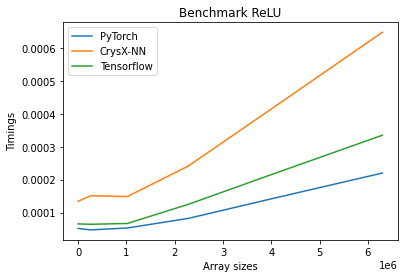

In [41]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark ReLU')
plt.show()

## Benchmark ReLU derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [42]:
def tf_relu_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        relu_values = tf.nn.relu(x)
    grad = g.gradient(relu_values, x)
    return grad#.numpy()

In [43]:
def torch_relu_grad(relu_values, x):
    device='cuda'
    gradient = torch.autograd.grad(outputs=relu_values, inputs=x,
                          grad_outputs=torch.ones(relu_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [44]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
gradientsTorch = torch_relu_grad(relu_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = ReLU_grad_cupy(X_cupy)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_relu_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
gradientsTF = g.gradient(relu_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [45]:
# Torch
print('PyTorch gradient only')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
%timeit -n 100 torch_relu_grad(relu_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 ReLU_grad_cupy(X_cupy)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_relu_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.relu(X_tf)


PyTorch gradient only
1.32 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
50.5 µs ± 7.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
412 µs ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
56.6 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Sigmoid

### Confirm that all frameworks give the same results

In [46]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)

# CrysX
sigmoid_crysx_nn_value = Sigmoid_cupy(X_cupy)

# Tensorflow
sigmoid_tf_value = tf.keras.activations.sigmoid(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(sigmoid_torch_value.cpu().detach().numpy() - cp.asnumpy(sigmoid_crysx_nn_value)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 1.1920929e-07


### Compare performance

In [47]:
# Torch
print('PyTorch')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
%timeit -n 100 sigmoid_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Sigmoid_cupy(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)


PyTorch
The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
28.6 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
The slowest run took 4.18 times longer than the fastest. This could mean that an intermediate result is being cached.
185 µs ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
66.8 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [48]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o sigmoid_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Sigmoid_cupy(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.sigmoid(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

14.3 µs ± 596 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
61.6 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52 µs ± 2.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.1 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
64.8 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
50 µs ± 2.59 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.5 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 4.94 times longer than the fastest. This could mean that an intermediate result is being cached.
196 µs ± 86.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52.8 µs ± 6.95 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.2 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 7.86 times longer than the fastest. This could mean that an intermediate result is being cached.
443 µs ± 162 µs per loop (mean ± std. dev. of 7 run

### Plot the results

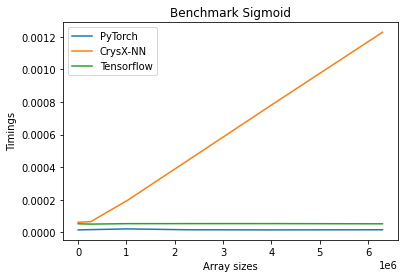

In [49]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Sigmoid')
plt.show()


## Benchmark Sigmoid derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [50]:
def tf_sigmoid_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        sigmoid_values = tf.nn.sigmoid(x)
    grad = g.gradient(sigmoid_values, x)
    return grad#.numpy()

In [51]:
def torch_sigmoid_grad(sigmoid_values, x):
    device='cuda'
    gradient = torch.autograd.grad(outputs=sigmoid_values, inputs=x,
                          grad_outputs=torch.ones(sigmoid_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [52]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
gradientsTorch = torch_sigmoid_grad(sigmoid_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Sigmoid_grad_cupy(X_cupy)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_sigmoid_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
gradientsTF = g.gradient(sigmoid_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 7.4505806e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [53]:
# Torch
print('PyTorch gradient only')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
%timeit -n 100 torch_sigmoid_grad(sigmoid_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Sigmoid_grad_cupy(X_cupy)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
# %timeit -n 100 g.gradient(sigmoid_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_sigmoid_grad(X_tf)
print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)



PyTorch gradient only
1.3 ms ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
254 µs ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
438 µs ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
52.5 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast for a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softmax

### Confirm that all frameworks give the same results

In [54]:
# Torch input
X_torch = torch.rand((1000,1000),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)

# CrysX
softmax_crysx_nn_value = Softmax_cupy(X_cupy)

# Tensorflow
softmax_tf_value = tf.keras.activations.softmax(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softmax_torch_value.cpu().detach().numpy() - softmax_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softmax_torch_value.cpu().detach().numpy() - cp.asnumpy(softmax_crysx_nn_value)).max())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Max abs diff b/w torch and tf 3.4924597e-10
Max abs diff b/w torch and CrysX 4.656613e-10


### Compare performance

In [55]:
# Torch
print('PyTorch')
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
%timeit -n 100 softmax_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Softmax_cupy(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.softmax(X_tf)


PyTorch
35.2 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


The slowest run took 12.62 times longer than the fastest. This could mean that an intermediate result is being cached.
1.09 ms ± 606 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
The slowest run took 42.99 times longer than the fastest. This could mean that an intermediate result is being cached.
511 µs ± 963 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [56]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.rand((n_size,n_size),requires_grad=True)
    X_torch = X_torch.cuda()
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    X_cupy = cp.asarray(X_crysx_nn)
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softmax_torch_func = torch.nn.Softmax() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o softmax_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Softmax_cupy(X_cupy)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

24.9 µs ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
111 µs ± 6.64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


81.4 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.4 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
309 µs ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 11.66 times longer than the fastest. This could mean that an intermediate result is being cached.
168 µs ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.9 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 12.32 times longer than the fastest. This could mean that an intermediate result is being cached.
1.12 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 43.30 times longer than the fastest. This could mean that an intermediate result is being cached.
523 µs ± 998 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
25.3 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 13.62 times longer than the fastest. This could mean 

### Plot the results

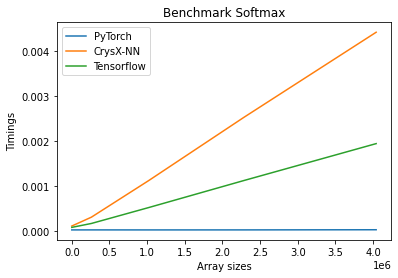

In [57]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softmax')
plt.show()


## Benchmark Softmax derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function.

Therefore, it is not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

#### Update: Seems to be really problematic to get the jacobian of Softmax wrt inputs in an efficient manner using the PyTorch framework. 

There are ways in which you can do it, but they would be slow. (https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16)

So take the timing results with a grain of salt.

In [58]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob#.numpy()

In [59]:
# Reference: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16
def torch_softmax_grad(wrt):
    jacobian = []
    softmax_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
    softmax_func.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(softmax_func, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

### Confirm that all frameworks give the same results

In [60]:
# Torch input
X_torch = torch.rand((300,100),requires_grad=True)
X_torch = X_torch.cuda()
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
X_cupy = cp.asarray(X_crysx_nn)
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
# softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
# softmax_torch_value = softmax_torch_func(X_torch)
device = 'cuda'
gradientsTorch = torch_softmax_grad(X_torch)#torch.autograd.grad(outputs=softmax_torch_value, inputs=X_torch,
#                           grad_outputs=torch.ones(softmax_torch_value.size()).to(device),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0]
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softmax_grad_cupy(X_cupy)
# print(gradientsCrysx)

# Tensorflow
# softmax_tf_value = tf.nn.softmax(X_tf)
gradientsTF = tf_softmax_grad(X_tf)
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - cp.asnumpy(gradientsCrysx)).max())


/usr/local/lib/python3.7/dist-packages/torch/autograd/functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


Max abs diff b/w torch and tf 3.7252903e-09
Max abs diff b/w torch and CrysX 4.452886059880257e-09


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [61]:
# Torch
print('PyTorch')
%timeit -n 2 torch_softmax_grad(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 2 Softmax_grad_cupy(X_cupy)

# Tensorflow
print('Tensorflow')
%timeit -n 2 tf_softmax_grad(X_tf)


PyTorch
9.39 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
CrysX-NN (crysx_nn)
738 µs ± 443 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)
Tensorflow
273 ms ± 7.85 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)
